<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 986, '日付': '2021-01-24T08:00:00.000Z'},
 {'小計': 618, '日付': '2021-01-25T08:00:00.000Z'},
 {'小計': 1026, '日付': '2021-01-26T08:00:00.000Z'},
 {'小計': 973, '日付': '2021-01-27T08:00:00.000Z'},
 {'小計': 1064, '日付': '2021-01-28T08:00:00.000Z'},
 {'小計': 868, '日付': '2021-01-29T08:00:00.000Z'},
 {'小計': 769, '日付': '2021-01-30T08:00:00.000Z'},
 {'小計': 633, '日付': '2021-01-31T08:00:00.000Z'},
 {'小計': 393, '日付': '2021-02-01T08:00:00.000Z'},
 {'小計': 556, '日付': '2021-02-02T08:00:00.000Z'},
 {'小計': 676, '日付': '2021-02-03T08:00:00.000Z'},
 {'小計': 734, '日付': '2021-02-04T08:00:00.000Z'},
 {'小計': 577, '日付': '2021-02-05T08:00:00.000Z'},
 {'小計': 639, '日付': '2021-02-06T08:00:00.000Z'},
 {'小計': 429, '日付': '2021-02-07T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-02-03 17:00:00+09:00,337,0,676,2021-02-03 17:00:00+09:00
2021-02-04 17:00:00+09:00,331,0,734,2021-02-04 17:00:00+09:00
2021-02-05 17:00:00+09:00,0,0,577,2021-02-05 17:00:00+09:00
2021-02-06 17:00:00+09:00,0,0,639,2021-02-06 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-02-03 17:00:00+09:00,337,0,676,2021-02-03 17:00:00+09:00,406.000000,2842.0,0.0,0.0,708.428571,4959.0
2021-02-04 17:00:00+09:00,331,0,734,2021-02-04 17:00:00+09:00,388.428571,2719.0,0.0,0.0,661.285714,4629.0
2021-02-05 17:00:00+09:00,0,0,577,2021-02-05 17:00:00+09:00,331.142857,2318.0,0.0,0.0,619.714286,4338.0
2021-02-06 17:00:00+09:00,0,0,639,2021-02-06 17:00:00+09:00,267.571429,1873.0,0.0,0.0,601.142857,4208.0
2021-02-07 17:00:00+09:00,0,0,429,2021-02-07 17:00:00+09:00,209.857143,1469.0,0.0,0.0,572.000000,4004.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-01-24 17:00:00+09:00,503,0,986,2021-01-24 17:00:00+09:00,635.428571,4448.0,0.0,0.0,1202.857143,8420.0,'21w03,Sun
2021-01-25 17:00:00+09:00,606,0,618,2021-01-25 17:00:00+09:00,591.000000,4137.0,0.0,0.0,1119.142857,7834.0,'21w04,Mon
2021-01-26 17:00:00+09:00,511,0,1026,2021-01-26 17:00:00+09:00,573.571429,4015.0,0.0,0.0,1088.571429,7620.0,'21w04,Tue
2021-01-27 17:00:00+09:00,515,0,973,2021-01-27 17:00:00+09:00,562.285714,3936.0,0.0,0.0,1045.571429,7319.0,'21w04,Wed
2021-01-28 17:00:00+09:00,454,0,1064,2021-01-28 17:00:00+09:00,549.285714,3845.0,0.0,0.0,987.428571,6912.0,'21w04,Thu
2021-01-29 17:00:00+09:00,401,0,868,2021-01-29 17:00:00+09:00,517.857143,3625.0,0.0,0.0,943.571429,6605.0,'21w04,Fri
2021-01-30 17:00:00+09:00,445,0,769,2021-01-30 17:00:00+09:00,490.714286,3435.0,0.0,0.0,900.571429,6304.0,'21w04,Sat
2021-01-31 17:00:00+09:00,404,0,633,2021-01-31 17:00:00+09:00,476.571429,3336.0,0.0,0.0,850.142857,5951.0,'21w04,Sun
2021-02-01 17:00:00+09:00,432,0,393,2021-02-01 17:00:00+09:00,451.714286,3162.0,0.0,0.0,818.000000,5726.0,'21w05,Mon
2021-02-02 17:00:00+09:00,369,0,556,2021-02-02 17:00:00+09:00,431.428571,3020.0,0.0,0.0,750.857143,5256.0,'21w05,Tue


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-01-17 17:00:00+09:00,1503.714286,10526
2021-01-24 17:00:00+09:00,1202.857143,8420
2021-01-31 17:00:00+09:00,850.142857,5951
2021-02-07 17:00:00+09:00,572.000000,4004
2021-01-03 17:00:00+09:00,804.333333,2413


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-01-24 17:00:00+09:00,503,0,986,2021-01-24 17:00:00+09:00,635.428571,4448.0,0.0,0.0,1202.857143,8420.0,'21w03,Sun,1202.857143,8420.0
2021-01-25 17:00:00+09:00,606,0,618,2021-01-25 17:00:00+09:00,591.000000,4137.0,0.0,0.0,1119.142857,7834.0,'21w04,Mon,NaN,NaN
2021-01-26 17:00:00+09:00,511,0,1026,2021-01-26 17:00:00+09:00,573.571429,4015.0,0.0,0.0,1088.571429,7620.0,'21w04,Tue,NaN,NaN
2021-01-27 17:00:00+09:00,515,0,973,2021-01-27 17:00:00+09:00,562.285714,3936.0,0.0,0.0,1045.571429,7319.0,'21w04,Wed,NaN,NaN
2021-01-28 17:00:00+09:00,454,0,1064,2021-01-28 17:00:00+09:00,549.285714,3845.0,0.0,0.0,987.428571,6912.0,'21w04,Thu,NaN,NaN
2021-01-29 17:00:00+09:00,401,0,868,2021-01-29 17:00:00+09:00,517.857143,3625.0,0.0,0.0,943.571429,6605.0,'21w04,Fri,NaN,NaN
2021-01-30 17:00:00+09:00,445,0,769,2021-01-30 17:00:00+09:00,490.714286,3435.0,0.0,0.0,900.571429,6304.0,'21w04,Sat,NaN,NaN
2021-01-31 17:00:00+09:00,404,0,633,2021-01-31 17:00:00+09:00,476.571429,3336.0,0.0,0.0,850.142857,5951.0,'21w04,Sun,850.142857,5951.0
2021-02-01 17:00:00+09:00,432,0,393,2021-02-01 17:00:00+09:00,451.714286,3162.0,0.0,0.0,818.000000,5726.0,'21w05,Mon,NaN,NaN
2021-02-02 17:00:00+09:00,369,0,556,2021-02-02 17:00:00+09:00,431.428571,3020.0,0.0,0.0,750.857143,5256.0,'21w05,Tue,NaN,NaN


### グラフ出力

In [12]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [13]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

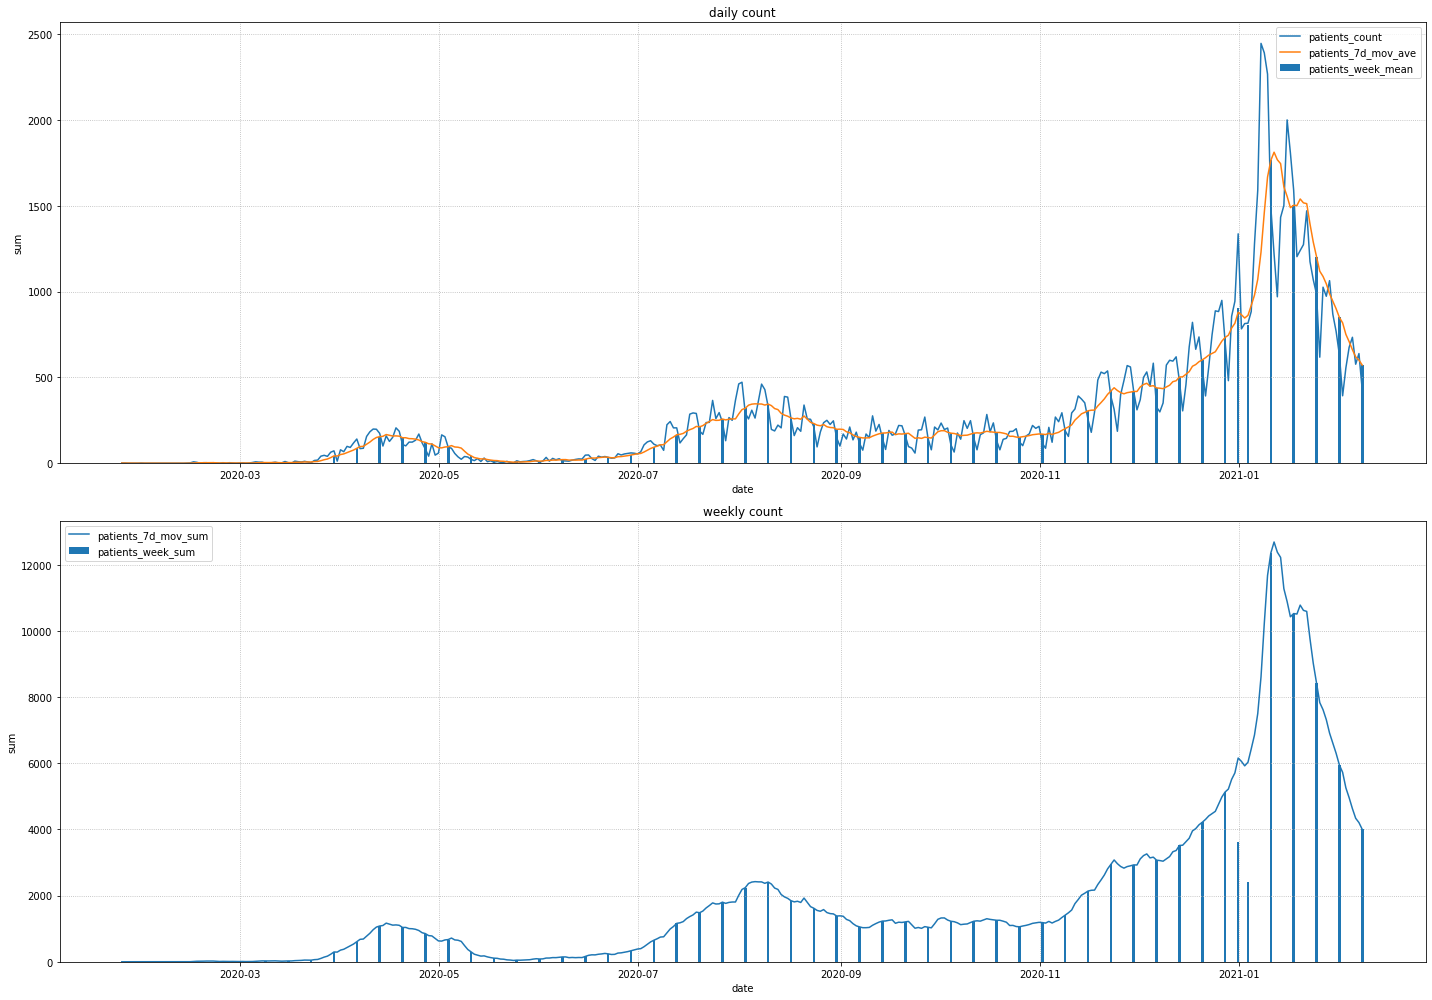

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [15]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [16]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [17]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [18]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [19]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
366,1.611475e+09,2021,1,24,0,0,0,1,0,0,0,366,0,292,503,635.428571,4448.0,0,0.0,0.0,986,1202.857143,8420.0
367,1.611562e+09,2021,1,25,0,1,0,0,0,0,0,367,0,293,606,591.000000,4137.0,0,0.0,0.0,618,1119.142857,7834.0
368,1.611648e+09,2021,1,26,0,0,0,0,0,1,0,368,0,294,511,573.571429,4015.0,0,0.0,0.0,1026,1088.571429,7620.0
369,1.611734e+09,2021,1,27,0,0,0,0,0,0,1,369,0,295,515,562.285714,3936.0,0,0.0,0.0,973,1045.571429,7319.0
370,1.611821e+09,2021,1,28,0,0,0,0,1,0,0,370,0,296,454,549.285714,3845.0,0,0.0,0.0,1064,987.428571,6912.0
371,1.611907e+09,2021,1,29,1,0,0,0,0,0,0,371,0,297,401,517.857143,3625.0,0,0.0,0.0,868,943.571429,6605.0
372,1.611994e+09,2021,1,30,0,0,1,0,0,0,0,372,0,298,445,490.714286,3435.0,0,0.0,0.0,769,900.571429,6304.0
373,1.612080e+09,2021,1,31,0,0,0,1,0,0,0,373,0,299,404,476.571429,3336.0,0,0.0,0.0,633,850.142857,5951.0
374,1.612166e+09,2021,2,1,0,1,0,0,0,0,0,374,0,300,432,451.714286,3162.0,0,0.0,0.0,393,818.000000,5726.0
375,1.612253e+09,2021,2,2,0,0,0,0,0,1,0,375,0,301,369,431.428571,3020.0,0,0.0,0.0,556,750.857143,5256.0


In [20]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            381 non-null    float64
 1   year                 381 non-null    int64  
 2   month                381 non-null    int64  
 3   day                  381 non-null    int64  
 4   Fri                  381 non-null    uint8  
 5   Mon                  381 non-null    uint8  
 6   Sat                  381 non-null    uint8  
 7   Sun                  381 non-null    uint8  
 8   Thu                  381 non-null    uint8  
 9   Tue                  381 non-null    uint8  
 10  Wed                  381 non-null    uint8  
 11  passed               381 non-null    int64  
 12  emergency            381 non-null    int64  
 13  em_passed            381 non-null    int64  
 14  contacts_count       381 non-null    int64  
 15  contacts_7d_mov_ave  381 non-null    flo

In [21]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.810000e+02,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,1.596269e+09,2020.099738,6.314961,15.787402,0.144357,0.141732,0.144357,0.144357,0.141732,0.141732,0.141732,190.000000,0.128609,123.283465,751.354331,750.592363,5254.136483,967.241470,967.241470,6770.690289,272.559055,267.995613,1875.926509
std,9.515186e+06,0.300044,3.528159,8.967453,0.351913,0.349234,0.351913,0.351913,0.349234,0.349234,0.349234,110.129469,0.335207,100.091976,461.840059,445.540009,3118.796979,878.301776,759.303579,5315.125056,384.245412,364.061402,2548.461326
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.588061e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,21.000000,453.000000,459.000000,3213.000000,0.000000,0.000000,0.000000,27.000000,24.571429,172.000000
50%,1.596269e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.000000,0.000000,116.000000,603.000000,612.714286,4289.000000,970.000000,1045.000000,7315.000000,156.000000,162.857143,1140.000000
75%,1.604477e+09,2020.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,285.000000,0.000000,211.000000,931.000000,937.142857,6560.000000,1540.000000,1535.857143,10751.000000,305.000000,308.857143,2162.000000
max,1.612685e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,380.000000,1.000000,306.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2447.000000,1812.714286,12689.000000


In [22]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.519010,0.492737,0.001295,-0.003735,-0.005542,-5.489397e-18,0.003735,0.005542,-0.001847,0.001847,1.000000e+00,-0.321354,0.990531,-0.080009,-0.039872,-0.039866,-0.308850,-0.322461,-0.322461,0.694919,0.731860,0.731880
year,5.190103e-01,1.000000,-0.484672,-0.074255,0.012821,-0.009690,1.282115e-02,0.012821,-0.009690,-0.009690,-0.009690,5.190103e-01,-0.127871,0.546806,0.012810,0.079381,0.079382,-0.367034,-0.424556,-0.424556,0.760340,0.833471,0.833466
month,4.927375e-01,-0.484672,1.000000,-0.006029,-0.017640,0.004255,-1.340122e-02,-0.009162,0.014933,0.008526,0.012798,4.927375e-01,-0.196775,0.454113,-0.092215,-0.118837,-0.118832,0.059864,0.106563,0.106563,-0.065079,-0.103269,-0.103243
day,1.295031e-03,-0.074255,-0.006029,1.000000,0.008917,-0.000437,3.079503e-03,-0.001090,0.007966,-0.006319,-0.012201,1.295031e-03,-0.004012,0.003583,-0.011569,-0.014112,-0.014117,0.005627,-0.014394,-0.014394,-0.008637,0.006117,0.006099
Fri,-3.734562e-03,0.012821,-0.017640,0.008917,1.000000,-0.166915,-1.687117e-01,-0.168712,-0.166915,-0.166915,-0.166915,-3.734562e-03,-0.001639,-0.001987,-0.026789,-0.006503,-0.006501,0.041751,-0.005443,-0.005443,0.051227,-0.001160,-0.001171
Mon,-5.542190e-03,-0.009690,0.004255,-0.000437,-0.166915,1.000000,-1.669151e-01,-0.166915,-0.165138,-0.165138,-0.165138,-5.542190e-03,0.001239,-0.005895,0.048097,0.003636,0.003638,0.188652,0.004114,0.004114,-0.102999,-0.003154,-0.003152
Sat,-5.489397e-18,0.012821,-0.013401,0.003080,-0.168712,-0.166915,1.000000e+00,-0.168712,-0.166915,-0.166915,-0.166915,9.649331e-19,-0.001639,0.001301,0.043855,-0.006503,-0.006501,-0.216736,-0.005443,-0.005443,0.054594,0.000712,0.000704
Sun,3.734562e-03,0.012821,-0.009162,-0.001090,-0.168712,-0.166915,-1.687117e-01,1.000000,-0.166915,-0.166915,-0.166915,3.734562e-03,-0.001639,0.004588,-0.022530,-0.006503,-0.006501,-0.200057,-0.005443,-0.005443,-0.032165,0.001964,0.001963
Thu,5.542190e-03,-0.009690,0.014933,0.007966,-0.166915,-0.165138,-1.669151e-01,-0.166915,1.000000,-0.165138,-0.165138,5.542190e-03,0.001239,0.003967,-0.007034,0.006142,0.006143,0.057559,0.004114,0.004114,0.074262,0.002654,0.002661
Tue,-1.847397e-03,-0.009690,0.008526,-0.006319,-0.166915,-0.165138,-1.669151e-01,-0.166915,-0.165138,1.000000,-0.165138,-1.847397e-03,0.001239,-0.002658,-0.022143,0.004528,0.004529,0.077403,0.004114,0.004114,-0.041264,-0.001513,-0.001508


---

In [23]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [24]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1.612339e+09,0,0,0,0,0,0,1,376,0,302,337,0,676,708.428571,4959.0
377,1.612426e+09,0,0,0,0,1,0,0,377,0,303,331,0,734,661.285714,4629.0
378,1.612512e+09,1,0,0,0,0,0,0,378,0,304,0,0,577,619.714286,4338.0
379,1.612598e+09,0,0,1,0,0,0,0,379,0,305,0,0,639,601.142857,4208.0


In [25]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
376,1.612339e+09,376,0,676,708.428571,4959.0
377,1.612426e+09,377,0,734,661.285714,4629.0
378,1.612512e+09,378,0,577,619.714286,4338.0
379,1.612598e+09,379,0,639,601.142857,4208.0


In [26]:
import seaborn as sns

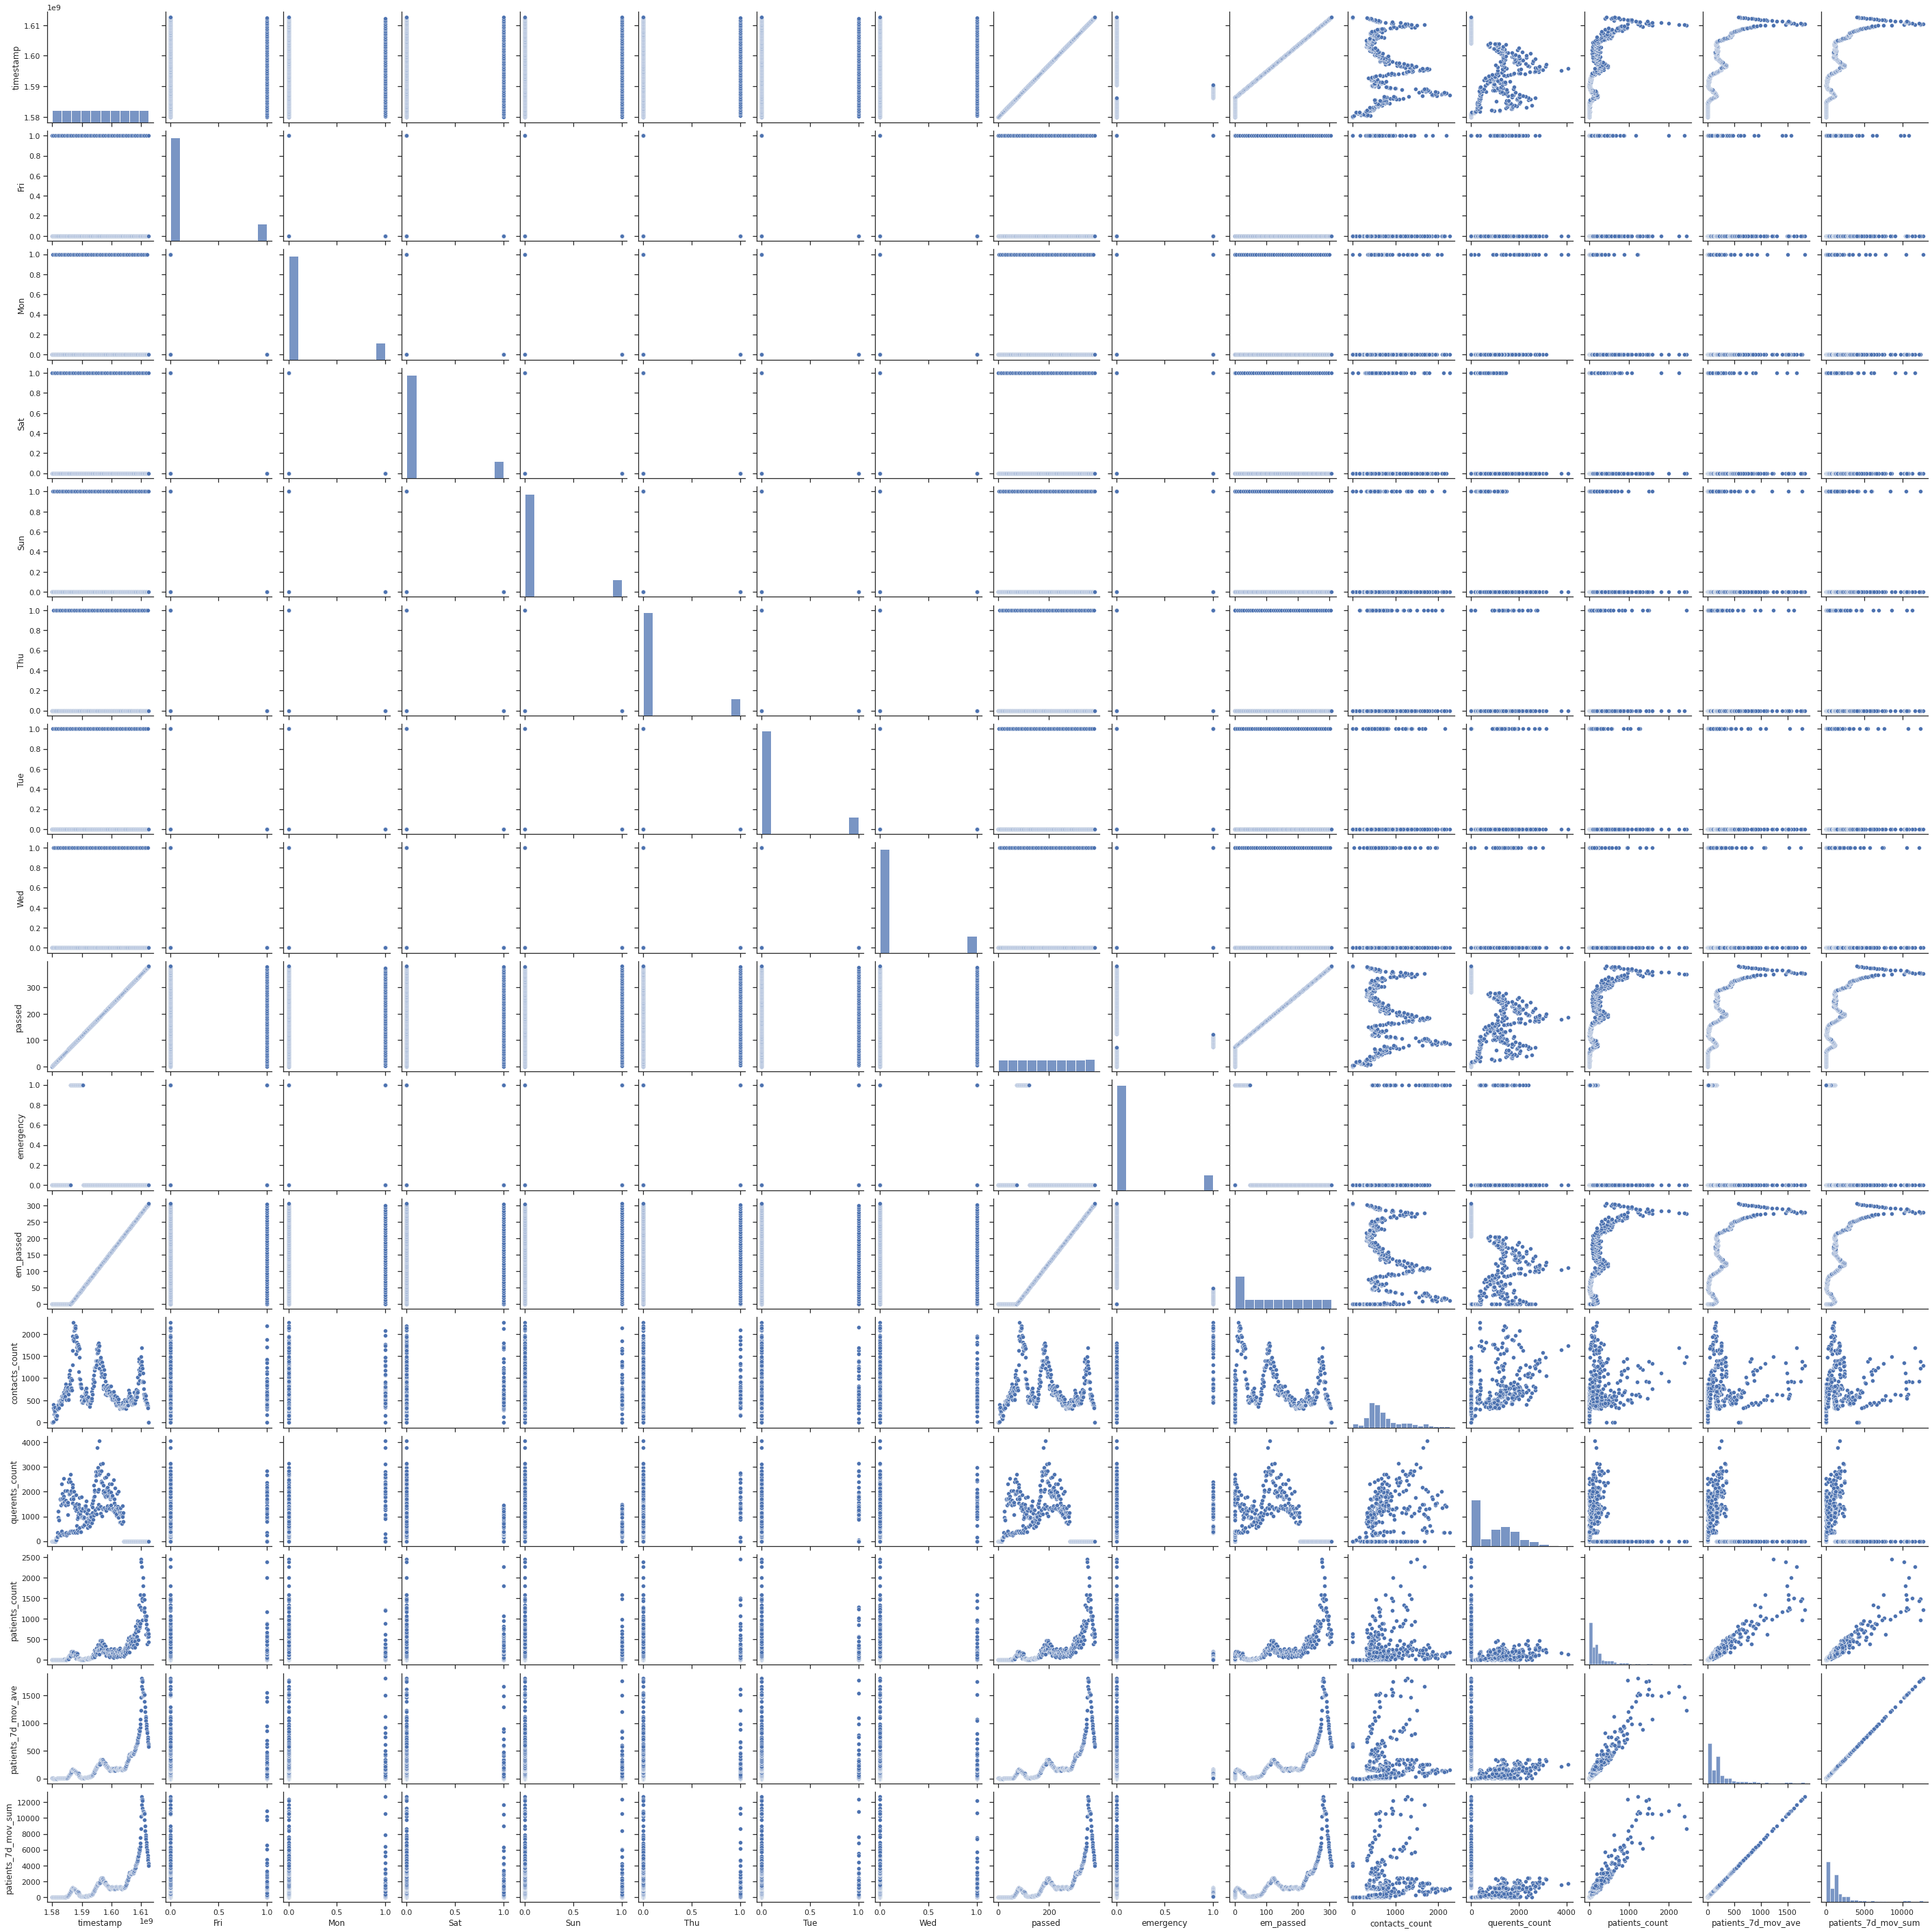

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

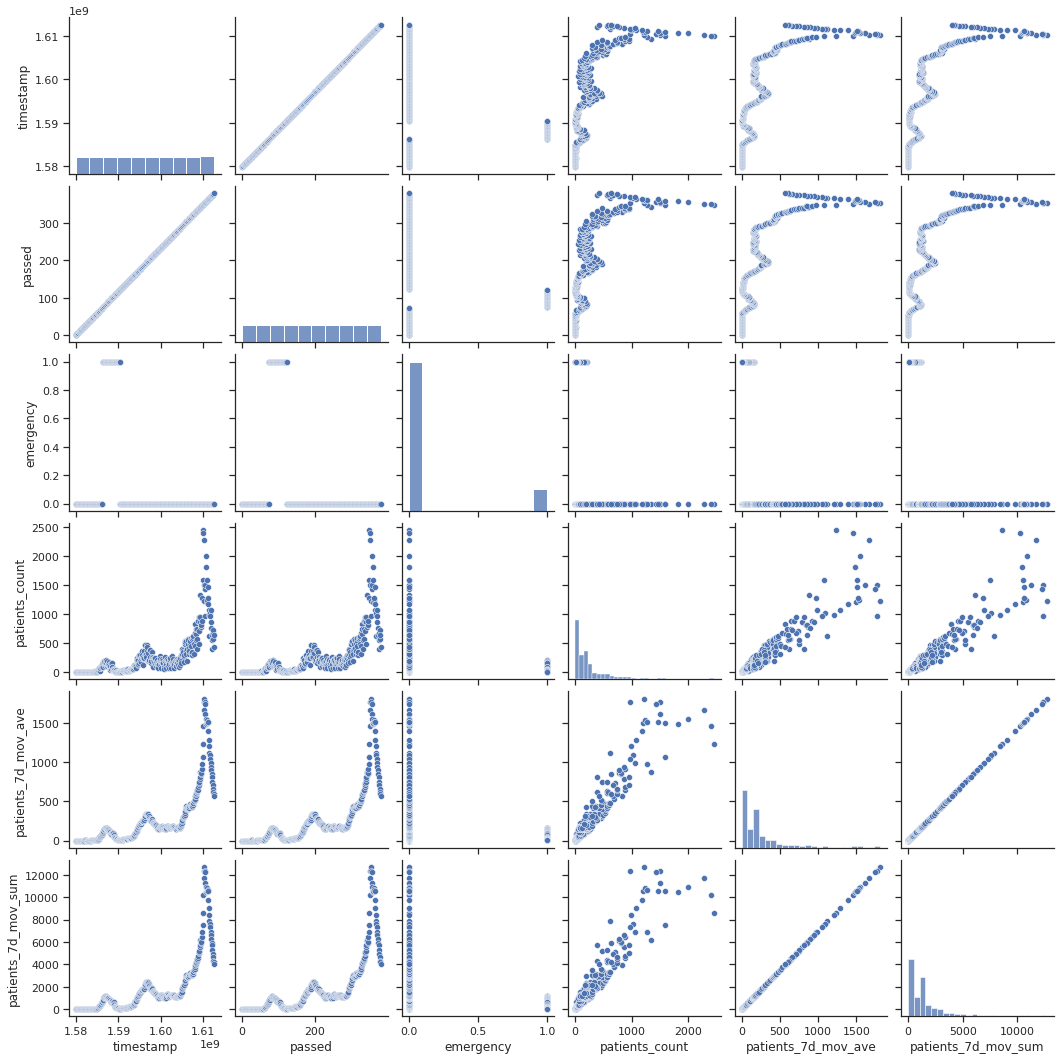

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.6.9
